## Introduction
Semantic textual similarity deals with determining how similar a pair of text documents are. The goal of the first task is to implement a new architecture by combining the ideas from papers
- Siamese Recurrent Architectures for Learning Sentence Similarity, Jonas Mueller et. al (will be referred as the AAAI paper)
- A Structured Self-Attentive Sentence Embedding, Zhouhan Lin et. al (will be referred as the ICLR paper) <br/><br/>
Furthermore, you'd be evaluating whether the new architecture improves the results of **Siamese Recurrent Architectures for Learning Sentence Similarity, Jonas Mueller et. al**. Your overall network architecture should look similar to the following figure. 
![Untitled%20Diagram.drawio%20%281%29.png](https://raw.githubusercontent.com/shahrukhx01/ocr-test/main/download.png)
<br/><br/>


Moreover, you'd be required to implement further helper functions that these papers propose i.e., attention penalty term for loss, etc.
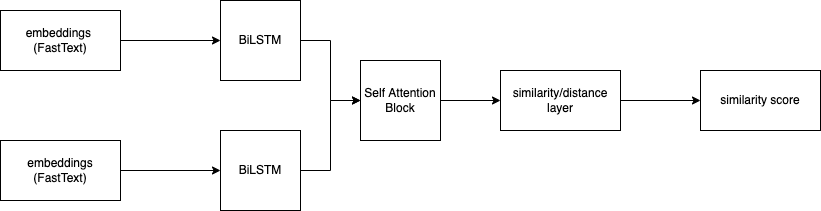

### SICK dataset
We will use SICK dataset throughout the project (at least in the first two tasks). To get more information about the dataset you can refer to the original [paper](http://www.lrec-conf.org/proceedings/lrec2014/pdf/363_Paper.pdf) on the dataset. You can download the dataset using one of the following links:
- [dataset page 1](https://marcobaroni.org/composes/sick.html)
- [dataset page 2](https://huggingface.co/datasets/sick)    

The relevant columns for the project are `sentence_A`, `sentence_B`, `relatedness_score`, where `relatedness_score` is the label. <br><br>
**Hint: For each task make sure to decide whether the label should be normalized or not.**<br><br>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from test import evaluate_test_set
import sts_data
from importlib import reload

## Part 1. Data pipeline (3 points)
Before starting working on the model, we must configure the data pipeline to load the data in the correct format. Please, implement the functions for processing the data.

### Part 1.1 Loading and preprocessing the data (1 point)
Download the SICK dataset and store it in [pandas](https://pandas.pydata.org/docs/index.html) `Dataframe`'s. You should use the official data split.  

Implement `load_data` method of `STSData` class in `sts_data.py`. The method must download the dataset and perform basic preprocessing. Minimal preprocessing required:  
1. normalize text to lower case
2. remove punctuations  
3. remove [stopwords](https://en.wikipedia.org/wiki/Stop_word) - we provided you with the list of English stopwords.
4. Optionally, any other preprocessing that you deem necessary.

All the preprocessing code must be contained in the `preprocessing.py` file.  
You can use Hugginface's [datasets library](https://huggingface.co/docs/datasets/) for easy dataset download.

### Part 1.2 Building vocabulary (1 point)
Before we can feed our text to the model it must be vectorized. We use 300 dimensional pretrained [FastText embeddings](https://fasttext.cc/docs/en/english-vectors.html) for mapping words to vectors. To know more general information about embeddings you can refer to [this video](https://www.youtube.com/watch?v=ERibwqs9p38) (even though, we use different types of embeddings - FastText vs Word2Vec described in the video - the general purpose of them is the same).  
In order to apply the embedding, we must first construct the vocabulary for data. Complete the `create_vocab` method of `STSData` class in `sts_data.py` where you concatenate each sentence pair, tokenize it and construct the vocabulary for the whole training data. You should use [torchtext](https://torchtext.readthedocs.io/en/latest/data.html
) for processing the data. For tokenization, you can use any library (or write your own tokenizer), but we recommend you to use tokenizer by [spacy](https://spacy.io/). Use the `fasttext.simple.300d` as pretrained vectors.  
In the end, you must have a vocabulary object capable of mapping your input to corresponding vectors. Remember that the vocabulary is created using only training data (not touching validation or test data).

### Part 1.3 Creating DataLoader (1 point)
Implement `get_data_loader` method of `STSData` class in `sts_data.py`. It must perform the following operations on each of the data splits:
1. vectorize each pair of the sentences by replacing all tokens with their index in vocabulary
2. normalize labels
3. convert everything to PyTorch tensors
4. pad every sentence so that all of them have the same length
5. create `STSDataset` from `dataset.py`
6. create PyTorch DataLoader out of the created dataset. 


We have provided you with the interfaces of possible helper functions, but you can change them as you need.   
In the end, you must have 3 data loaders for each of the splits.

In [3]:
reload(sts_data)
from sts_data import STSData

columns_mapping = {
        "sent1": "sentence_A",
        "sent2": "sentence_B",
        "label": "relatedness_score",
    }
dataset_name = "sick"
sick_data = STSData(
    dataset_name=dataset_name,
    columns_mapping=columns_mapping,
    normalize_labels=True,
    normalization_const=5.0,
)
batch_size = 64

sick_dataloaders = sick_data.get_data_loader(batch_size=batch_size)

INFO:root:loading and preprocessing data...
100%|██████████| 3/3 [00:00<00:00, 750.10it/s]
INFO:root:Four kids are doing backbends in the park
INFO:root:Four children are doing backbends in the park
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\nlp_project_nnti\task3\preprocess.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['train']['sentence_A'] = dataset['train']['sentence_A'].str.replace(self.punctuation_regex, '')
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\nlp_project_nnti\task3\preprocess.py:49: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['train']['sentence_B'] = dataset['train']['sentence_B'].str.replace(self.punctuation_regex, '')
c:\Users\laure\Documents\NNTI\nlp_project_nnti 2\nlp_project_nnti\task3\preprocess.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['test']['sentence_A'] = dat

Testing vocab. Index for kids is 65
Testing vocab. Index for sentence ['kids', 'playing', 'yard', 'standing', 'background'] is [65, 4, 144, 6, 141]
<unk>
<pad>
woman
Index(['id', 'sentence_A', 'sentence_B', 'label', 'relatedness_score',
       'entailment_AB', 'entailment_BA', 'sentence_A_original',
       'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset'],
      dtype='object')
max len a: 14, max_len b: 14, max_len 14
[228, 93, 7, 572, 368, 1, 1, 1, 1, 1, 1, 1, 1, 1]
max len a: 12, max_len b: 14, max_len 14
[5, 10, 41, 14, 22, 1, 1, 1, 1, 1, 1, 1, 1, 1]
max len a: 14, max_len b: 14, max_len 14
[1347, 12, 16, 164, 1287, 180, 1, 1, 1, 1, 1, 1, 1, 1]


## Part 2. Model Configuration & Hyperparameter Tuning (3 points)
In this part, you are required to define a model capable of learning self-attentive sentence embeddings described in [this ICLR paper](https://arxiv.org/pdf/1703.03130.pdf). The sentence embedding learned by this model will be used for computing the similarity score instead of the simpler embeddings described in the original AAAI paper.  
Please familiarize yourself with the model described in the ICLR paper and implement `SiameseBiLSTMAttention` and `SelfAttention` classes in `siamese_lstm_attention.py`. Remember that you must run the model on each sentence in the sentence pair to calculate the similarity between them. You can use `similarity_score` from `utils.py` to compute the similarity score between two sentences. 
  
To get more theoretical information about attention mechanisms you can refer to [this chapter](https://web.stanford.edu/~jurafsky/slp3/10.pdf) of ["Speech and Language Processing" book](https://web.stanford.edu/~jurafsky/slp3/) by Dan Jurafsky and James H. Martin, where the attention mechanism is described in the context of the machine translation task. 

Finally, once your implementation works on the default parameters stated below, make sure to perform **hyperparameter tuning** to find the best combination of hyperparameters.

In [4]:
hyper_param_search=True

output_size = 128
hidden_size = 403
vocab_size = len(sick_data.vocab)
embedding_size = 300
embedding_weights = sick_data.vocab.vectors
lstm_layers = 4
learning_rate = 0.00048586475278877557
fc_hidden_size = 89
max_epochs = 200
bidirectional = True
dropout = 0.12354567224086944
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## self attention config
self_attention_config = {
    "hidden_size": 400,  ## refers to variable 'da' in the ICLR paper
    "output_size": 14,  ## refers to variable 'r' in the ICLR paper
    "penalty": 0.1965166853622733,  ## refers to penalty coefficient term in the ICLR paper
}

attention_encoder_config = {
    "n_layers": 4,  ## number of encoder layers
    "n_heads": 16,  ## heads in multi-head attention
    "expansion": 4, ## encoder feed forward embedding size expansion factor
    "vocab_max": 15 ## max sequence length
}
pad_index = sick_data.vocab.stoi['<pad>']

In [5]:
from train import train_model, genetic_hyperparam_search

if hyper_param_search:
    genetic_hyperparam_search(data_loader=sick_dataloaders, device=device, vocab_size=vocab_size, max_epochs=20, num_gens=30, pad_index=pad_index)

INFO:root:Finding best hyperparameters using genetic algorithm
INFO:root:starting generation 0
INFO:root:Starting train for model with parameters fc=400, dropout=0.43877872997850625, lr=0.001, e_layers=5, output_size=220, embedding_size=300
100%|██████████| 20/20 [00:49<00:00,  2.45s/it]
INFO:root:0.03985115513205528
INFO:root:Starting train for model with parameters fc=64, dropout=0.3558505449215735, lr=0.001, e_layers=4, output_size=221, embedding_size=300
100%|██████████| 20/20 [00:39<00:00,  1.98s/it]
INFO:root:0.0353916697204113
INFO:root:Starting train for model with parameters fc=256, dropout=0.0032588570469112565, lr=8e-05, e_layers=6, output_size=228, embedding_size=300
100%|██████████| 20/20 [00:56<00:00,  2.85s/it]
INFO:root:0.031152017414569855
INFO:root:Starting train for model with parameters fc=64, dropout=0.05080044381733295, lr=0.001, e_layers=1, output_size=300, embedding_size=600
100%|██████████| 20/20 [00:18<00:00,  1.09it/s]
INFO:root:0.03979550302028656
INFO:root:

## Part 3. Training (2 points)  
Perform the final training of the model by implementing functions in `train.py` after setting values of your best-chosen hyperparameters. Note you can use the same training function when performing hyperparameter tuning.
- **What is a good choice of performance metric here for evaluating your model?** [Max 2-3 lines]
- **What other performance evaluation metric can we use here for this task? Motivate your answer.**[Max 2-3 lines]

In [36]:
## Best found hyperparams:hidden_size=80,lstm_layers=2,fc=76,dropout=1e-07,a_hs=98,a_os=21,p=0.7502554332823722, lr=2.225080318923014e-05, e_layers=1
## INFO:root:Starting train for model with parameters hidden_size=258,lstm_layers=2,fc=257,dropout=1e-07,a_hs=408,a_os=15,p=0.0, lr=3.967019319929535e-05, e_layers=4
##  hidden_size=511,lstm_layers=2,fc=423,dropout=0.0901198887332128,a_hs=428,a_os=19,p=0.0, lr=8e-05, e_layers=4

#### After some changes to model (mask)
## with parameters hidden_size=529,lstm_layers=4,fc=362,dropout=1e-07,a_hs=128,a_os=18,p=0.0, lr=0.0004930708179433092, e_layers=1, output_size=183


batch_size = 64
vocab_size = len(sick_data.vocab)
embedding_size = 600
learning_rate = 8e-05#0.0004930708179433092
max_epochs = 40
dropout = 0.166
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## encoder attention config
attention_encoder_config = {
    "n_layers": 24,  ## number of encoder layers
    "n_heads": 18,  ## heads in multi-head attention
    "expansion": 4, ## encoder feed forward embedding size expansion factor
    "vocab_max": 14 ## max sequence length
}

In [37]:
from siamese_lstm_attention import SiameseBiLSTMAttention
## init siamese lstm
siamese_lstm_attention = SiameseBiLSTMAttention(
    batch_size=batch_size,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    attention_encoder_config=attention_encoder_config,
    device=device,
    pad_index=pad_index,
    dropout=dropout
)

## move model to device
siamese_lstm_attention.to(device)

SiameseBiLSTMAttention(
  (word_embeddings): Embedding(1962, 600)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attention): MultiHeadSelfAttention(
          (Q): Linear(in_features=600, out_features=600, bias=False)
          (K): Linear(in_features=600, out_features=600, bias=False)
          (V): Linear(in_features=600, out_features=600, bias=False)
          (output_layer): Linear(in_features=600, out_features=600, bias=True)
        )
        (Dropout): Dropout(p=0.166, inplace=False)
        (LayerNorm1): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
        (LayerNorm2): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
        (FeedForward): Sequential(
          (0): Linear(in_features=600, out_features=2400, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2400, out_features=600, bias=True)
        )
      )
      (1): EncoderBlock(
        (attention): MultiHeadSelfAttention(
          (Q): Linear(in_features=

In [38]:
from train import train_model
torch.cuda.empty_cache()
optimizer = torch.optim.Adam(params=siamese_lstm_attention.parameters(), lr=learning_rate)

best_model, train_losses, train_accs, val_losses, val_accs = train_model(
    model=siamese_lstm_attention,
    optimizer=optimizer,
    dataloader=sick_dataloaders,
    data=sick_data,
    max_epochs=max_epochs,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

  0%|          | 0/40 [00:00<?, ?it/s]INFO:root:Epoch: 0
INFO:root:new model saved
INFO:root:Train loss: 0.030867351219058037 - acc: 0.5234798842629589 -- Validation loss: 0.005528420675545931 - acc: 0.5736055236495162 - mse: 0.04422736540436745
  2%|▎         | 1/40 [00:06<04:30,  6.94s/it]INFO:root:Epoch: 1
INFO:root:new model saved
INFO:root:Train loss: 0.02045924961566925 - acc: 0.6246411447475092 -- Validation loss: 0.004232189152389765 - acc: 0.6258963010998759 - mse: 0.03385751694440842
  5%|▌         | 2/40 [00:13<04:18,  6.80s/it]INFO:root:Epoch: 2
INFO:root:Train loss: 0.017335696145892143 - acc: 0.657260144577776 -- Validation loss: 0.005834297742694616 - acc: 0.44039838740115667 - mse: 0.04667438939213753
  8%|▊         | 3/40 [00:20<04:04,  6.62s/it]INFO:root:Epoch: 3
INFO:root:new model saved
INFO:root:Train loss: 0.017023799940943718 - acc: 0.658129341132633 -- Validation loss: 0.005173504818230867 - acc: 0.6407311485272587 - mse: 0.04138803854584694
 10%|█         | 4/4

8


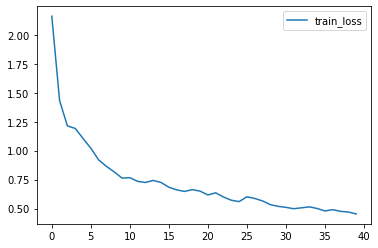

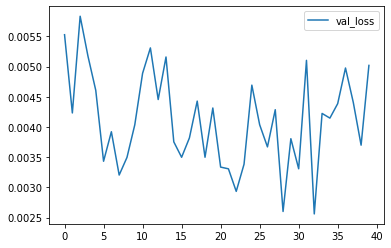

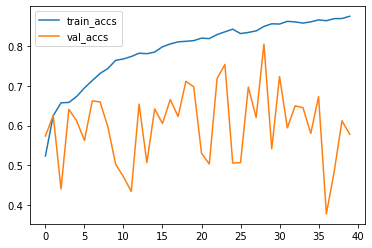

In [39]:
import matplotlib.pyplot as plt
print(len(sick_dataloaders['validation']))
plt.plot(train_losses[:], label='train_loss')
plt.legend()
plt.savefig('train_losses_tests')
plt.show()

plt.plot(val_losses[:], label='val_loss')
plt.legend()
plt.savefig('val_losses_test')
plt.show()

plt.plot(train_accs, label='train_accs')
plt.plot(val_accs, label='val_accs')
plt.legend()
plt.savefig('accuracies_test')
plt.show()

## Part 4. Evaluation and Analysis (2 points)  
Implement function evaluate_test_set to calculate the final accuracy of the performance evaluation metric on the test data.  
Compare the result with the original AAAI paper. Сomment on effect of penalty loss on model capacity. Did the inclusion of the self-attention block improve the results? If yes, then how? Can you think of additional techniques to improve the results? Briefly answer these questions in the markdown cells.

In [41]:
from test import evaluate_test_set

load_model=True
if load_model:
    best_model = SiameseBiLSTMAttention(
        batch_size=batch_size,
        vocab_size=vocab_size,
        embedding_size=embedding_size,
        attention_encoder_config=attention_encoder_config,
        device=device,
        pad_index=pad_index,
        dropout=dropout
    )
    ## move model to device
    best_model.to(device)
    best_model.load_state_dict(torch.load("siamese_lstm_attention.pth"))
    best_model.eval()


test_acc, r, rho, mse, least_1, least_2, most_1, most_2  = evaluate_test_set(
    model=best_model,
    data_loader=sick_dataloaders,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

print('final accuracy on test set is {}'.format(test_acc))
print('pearsons r test set is {}'.format(r))
print('spearman rho on test set is {}'.format(rho))
print('mean square error on test set is {}'.format(mse))

INFO:root:Evaluating accuracy on test set


Worst score is 0.0 and should be 4.599999904632568
Best score is 5.000000596046448 and should be 5.0
tensor([ 28, 149,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1])
tensor([ 28, 149,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1])
final accuracy on test set is 0.20354469946973242
pearsons r test set is (0.7239829371609064, 0.0)
spearman rho on test set is SpearmanrResult(correlation=0.6067064319998835, pvalue=0.0)
mean square error on test set is 0.03245119750499725


In [42]:
worst_sen_1 = [sick_data.vocab.itos[token] for token in least_1]
print(worst_sen_1)
worst_sen_2 = [sick_data.vocab.itos[token] for token in least_2]
print(worst_sen_2)

best_sen_1 = [sick_data.vocab.itos[token] for token in most_1]
print(best_sen_1)
best_sen_2 = [sick_data.vocab.itos[token] for token in most_2]
print(best_sen_2)



## Test on some manual sentences
test_sentences1 = ['the cat sits outside <pad> <pad>',
             'a man is playing guitar <pad>',
             'the new movie is awesome <pad>',
             'the dog plays in the garden',
             'a woman working in an office']

test_sentences2 = ['the dog plays in the garden',
              'a woman watches TV <pad> <pad>',
              'the new movie is so great',
              'the dog plays in the garden',
              'a boy eating ice cream <pad>']

tokenized_sen1= list()             
for sentence in test_sentences1:
    tokenized = [sick_data.vocab.stoi[word] for word in sentence.split()]
    tokenized_sen1.append(tokenized)
tokenized_sen1 = torch.tensor(tokenized_sen1).to(device)

tokenized_sen2= list()             
for sentence in test_sentences2:
    tokenized = [sick_data.vocab.stoi[word] for word in sentence.split()]
    tokenized_sen2.append(tokenized)
tokenized_sen2=torch.tensor(tokenized_sen2).to(device)

predic = best_model(tokenized_sen1, tokenized_sen2)

for i in range(len(test_sentences1)):
    print('similarity: {:.2f} for sentences  {} - {}'.format(predic[i]*5.0, test_sentences1[i], test_sentences2[i]))


['laptop', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['cat', 'stuck', 'ceiling', 'fan', 'moving', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['cat', 'stuck', 'moving', 'ceiling', 'fan', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
similarity: 4.44 for sentences  the cat sits outside <pad> <pad> - the dog plays in the garden
similarity: 4.15 for sentences  a man is playing guitar <pad> - a woman watches TV <pad> <pad>
similarity: 5.00 for sentences  the new movie is awesome <pad> - the new movie is so great
similarity: 5.00 for sentences  the dog plays in the garden - the dog plays in the garden
similarity: 3.86 for sentences  a woman working in an office - a boy eating ice cream <pad>
